# Detecting straight from dataset

## Libraries

In [1]:
import os
import cv2
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image as Image
import Augmentor
import itertools

%matplotlib inline

# Libraries for TensorFlow
from tensorflow.keras.preprocessing import image as imagePrep
from tensorflow.keras import models, layers
from tensorflow.keras.models import clone_model
from tensorflow.keras.applications import resnet50
from tensorflow.keras import backend as K

from tensorflow.keras.applications.resnet50 import preprocess_input

import tensorflow as tf

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.utils import class_weight
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

In [2]:
print("Num GPUs Available: ", tf.config.list_physical_devices())
K.image_data_format()

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


'channels_last'

In [3]:
Labels = ['file','label']
ReverseDownPath = r'Data\OriginalPantsDataset\ReverseDown'
ReverseUpPath = r'Data\OriginalPantsDataset\ReverseUp'
RightDownPath = r'Data\OriginalPantsDataset\RightDown'
RightUpPath = r'Data\OriginalPantsDataset\RightUp'
AllPaths = [ReverseDownPath,ReverseUpPath,RightDownPath,RightUpPath]
originalFilename = r'Data\OriginalPantsDataset\pants_dataset.csv'

## Creating CSV Images classification

In [4]:
allFiles = []
for iPath, path in enumerate(AllPaths):
    if(iPath == 0):
        pathName = "Reverse_Back"
    elif(iPath == 1):
        pathName = "Reverse_Front"
    elif(iPath == 2):
        pathName = "Alright_Back"
    elif(iPath == 3):
        pathName = "Alright_Front"
    
    for files in os.listdir(path):
        finalPath = os.path.join(path, files)
        allFiles.append([finalPath,pathName])

In [5]:
with open(originalFilename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(Labels) 
    for row in allFiles:
        csvwriter.writerow(row)


## Data augmentation

Let's create more data from the existing one. We want to load images, compress them, make 100 variations of each, and save them

In [6]:
BATCH_SIZE = 8
EPOCHS = 60
WIDTH = 540
HEIGHT = 540
STEPS_EPOCH = 50
augmentedDataSetPath = r'PantsDataset'

In [7]:
def saveImage(image, folderName, iPath, iRange, iFile):
    name = 'P_'+str(iPath)+str(iFile)+str(iRange)+'.jpg'
    if not os.path.exists(augmentedDataSetPath):
        os.mkdir(augmentedDataSetPath)
    finalDest = os.path.join(augmentedDataSetPath,folderName)
    if not os.path.exists(finalDest):
        os.mkdir(finalDest)
    finalDest = os.path.join(finalDest,name)

    image.save(finalDest, "JPEG", optimize = True)#, quality = 10)

In [8]:
allNewFiles = []
for iPath, path in enumerate(AllPaths):
    if(iPath == 0):
        pathName = "Reverse_Back"
    elif(iPath == 1):
        pathName = "Reverse_Front"
    elif(iPath == 2):
        pathName = "Alright_Back"
    elif(iPath == 3):
        pathName = "Alright_Front"
        
    for iFile, file in enumerate(os.listdir(path)):
        fullPath = os.path.join(path, file)
        image = Image.open(fullPath)
        image = image.resize((WIDTH, HEIGHT))
        saveImage(image, pathName,iPath, 0, iFile)
        print('Compressed ' + file)

Compressed IMG_20220329_190235.jpg
Compressed IMG_20220329_190237.jpg
Compressed IMG_20220329_190239.jpg
Compressed IMG_20220329_190241.jpg
Compressed IMG_20220329_190243.jpg
Compressed IMG_20220329_190245.jpg
Compressed IMG_20220329_190248.jpg
Compressed IMG_20220329_190251.jpg
Compressed IMG_20220329_190254.jpg
Compressed IMG_20220329_190256.jpg
Compressed IMG_20220329_190543.jpg
Compressed IMG_20220329_190549.jpg
Compressed IMG_20220329_190552.jpg
Compressed IMG_20220329_190557.jpg
Compressed IMG_20220329_190600.jpg
Compressed IMG_20220329_190602.jpg
Compressed IMG_20220329_190605.jpg
Compressed IMG_20220329_190608.jpg
Compressed IMG_20220329_190610.jpg
Compressed IMG_20220329_190630.jpg
Compressed IMG_20220329_190142.jpg
Compressed IMG_20220329_190145.jpg
Compressed IMG_20220329_190148.jpg
Compressed IMG_20220329_190150.jpg
Compressed IMG_20220329_190153.jpg
Compressed IMG_20220329_190159.jpg
Compressed IMG_20220329_190202.jpg
Compressed IMG_20220329_190204.jpg
Compressed IMG_20220

# Making the generators

In [9]:
p = Augmentor.Pipeline(augmentedDataSetPath)
p.resize(1, WIDTH, HEIGHT)
p.flip_left_right(0.5)
p.rotate(probability=0.3, max_left_rotation=5, max_right_rotation=5)
p.skew(0.4, 0.5)#p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5)
p.status()

Initialised with 80 image(s) found.
Output directory set to PantsDataset\output.Operations: 4
	0: Resize (probability=1 width=540 height=540 resample_filter=BICUBIC )
	1: Flip (probability=0.5 top_bottom_left_right=LEFT_RIGHT )
	2: RotateRange (probability=0.3 max_left_rotation=-5 max_right_rotation=5 )
	3: Skew (probability=0.4 skew_type=RANDOM magnitude=0.5 )
Images: 80
Classes: 4
	Class index: 0 Class label: Alright_Back 
	Class index: 1 Class label: Alright_Front 
	Class index: 2 Class label: Reverse_Back 
	Class index: 3 Class label: Reverse_Front 
Dimensions: 1
	Width: 540 Height: 540
Formats: 1
	 JPEG

You can remove operations using the appropriate index and the remove_operation(index) function.


In [10]:
train_set = p.keras_generator(batch_size=BATCH_SIZE)

In [11]:
csvFile = pd.read_csv('Data\OriginalPantsDataset\pants_dataset.csv')
csvFile.head()
generator = imagePrep.ImageDataGenerator()
test_set = generator.flow_from_dataframe(
    dataframe=csvFile,
    x_col="file",
    y_col="label",
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 80 validated image filenames belonging to 4 classes.


In [12]:
def checkPointCreation(checkpoint_path):
    print("saving checkpoint")
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    return cp_callback

In [13]:
def generateWeights(labels):
    class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(labels),y=labels)
    leng = max(labels)
    class_weight_dict = {i : class_weights[i] for i in range(leng+1)}
    print(class_weight_dict)
    return class_weight_dict

In [14]:
def generateModel(classesAmount):
    input_layer = layers.Input(shape=(WIDTH,HEIGHT,3)) #We set the input layer to the data format we desire

    resNet=resnet50.ResNet50(weights='imagenet', input_tensor=input_layer,include_top=False) #We get the resnet model
    last_layer=resNet.output #We take output layers of resnet
    flatten=layers.Flatten()(last_layer) # Add flatten layer: we are extending Neural Network by adding flattn layer
    
    # Add dense layer to the final output layer
    output_layer = layers.Dense(classesAmount,activation='softmax')(flatten)

    # Creating model with input and output layer
    model=models.Model(inputs=input_layer,outputs=output_layer)
    model.summary()

    for layer in model.layers[:-1]: #Freezing lower layers (in this case only lower layer)
        layer.trainable=False
    model.summary()
    return clone_model(model)

In [15]:
def load_weights(cp_path):
    print("Getting weights")
    current_Epoch = 0
    filepath = ''
    if os.path.exists(cp_path):
        for filename in os.listdir(cp_path):
            f = os.path.join(cp_path, filename)
            # checking if it is a file
            if os.path.isfile(f):
                try:
                    lsp = filename.split('-')[1]
                    num = int(lsp.split('.')[0])
                    if(current_Epoch <= num):
                        current_Epoch = num
                        file = filename.split('.index')[0]
                        filepath = os.path.join(cp_path, file)
                        print(filepath)
                except:
                    print("not this")
        print("Starting from epoch " + str(current_Epoch))
    else:
        os.mkdir(cp_path)
    return current_Epoch, filepath

In [16]:
"""
Function extracted from https://deeplizard.com/learn/video/km7pxKy4UHU to create a confusion matrix
"""
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# First Test

In [17]:
cp_path = "checkPoints/model/cp-{epoch:04d}.ckpt"
cp_callback = checkPointCreation(cp_path)

saving checkpoint


In [18]:
model = generateModel(len(p.class_labels))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 540, 540, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 546, 546, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 270, 270, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 conv2_block2_add (Add)         (None, 135, 135, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 135, 135, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 135, 135, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 135, 135, 64  256        ['conv2_block3_1_conv[0][0]']    
 ization) 

 conv3_block2_3_conv (Conv2D)   (None, 68, 68, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 68, 68, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 68, 68, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 68, 68, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 34, 34, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 34, 34, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 34, 34, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
          

 conv5_block1_2_relu (Activatio  (None, 17, 17, 512)  0          ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 17, 17, 2048  2099200     ['conv4_block6_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 17, 17, 2048  1050624     ['conv5_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 17, 17, 2048  8192       ['conv5_block1_0_conv[0][0]']    
 ization) 

__________________________________________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 540, 540, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 546, 546, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 270, 270, 64  9472        ['conv1_pad[0][0]']              
                                )                                                             

                                                                                                  
 conv2_block2_add (Add)         (None, 135, 135, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 135, 135, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 135, 135, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 68, 68, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 68, 68, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 68, 68, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 68, 68, 512)  0           ['conv3_block2_add[0][0]']       
          

                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 34, 34, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
          

 conv4_block4_2_relu (Activatio  (None, 34, 34, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 34, 34, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 34, 34, 1024  0           ['conv4_block3_out[0][0]',       
          

                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 17, 17, 512)  0          ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 17, 17, 2048  2099200     ['conv4_block6_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 17, 17, 2048  1050624     ['conv5_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv5_blo

Total params: 25,955,204
Trainable params: 2,367,492
Non-trainable params: 23,587,712
__________________________________________________________________________________________________


In [19]:
currentEpoch, file = load_weights("checkPoints/model")
if(currentEpoch != 0):
    model.load_weights(file)

Getting weights


In [20]:
model.fit(train_set,steps_per_epoch=STEPS_EPOCH,epochs=EPOCHS,initial_epoch = currentEpoch,verbose=True, validation_data = test_set,callbacks=[cp_callback])

Epoch 1/60
50/50 [==============================] - ETA: 0s - loss: 4.7133 - accuracy: 0.3250
Epoch 1: saving model to checkPoints/model\cp-0001.ckpt
50/50 [==============================] - 53s 892ms/step - loss: 4.7133 - accuracy: 0.3250 - val_loss: 1293.1304 - val_accuracy: 0.2500
Epoch 2/60
50/50 [==============================] - ETA: 0s - loss: 2.5648 - accuracy: 0.3675
Epoch 2: saving model to checkPoints/model\cp-0002.ckpt
50/50 [==============================] - 23s 451ms/step - loss: 2.5648 - accuracy: 0.3675 - val_loss: 645.1997 - val_accuracy: 0.3625
Epoch 3/60
50/50 [==============================] - ETA: 0s - loss: 2.4847 - accuracy: 0.3750
Epoch 3: saving model to checkPoints/model\cp-0003.ckpt
50/50 [==============================] - 21s 426ms/step - loss: 2.4847 - accuracy: 0.3750 - val_loss: 258.8895 - val_accuracy: 0.5000
Epoch 4/60
50/50 [==============================] - ETA: 0s - loss: 2.6178 - accuracy: 0.3750
Epoch 4: saving model to checkPoints/model\cp-0004.ck

KeyboardInterrupt: 

In [21]:
if(currentEpoch < EPOCHS):
    model.save('saved_model/model')

INFO:tensorflow:Assets written to: saved_model/model\assets


In [22]:
model = models.load_model('saved_model/model')
predictions = model.predict(test_set)
rounded_predictions = np.argmax(predictions, axis=-1)
model.evaluate(test_set)

10/10 [==============================] - 7s 599ms/step - loss: 103.7777 - accuracy: 0.7375


[103.7776870727539, 0.737500011920929]

Confusion matrix, without normalization
[[ 9  1  9  1]
 [ 4  2 14  0]
 [ 5  0  8  7]
 [ 4  7  5  4]]


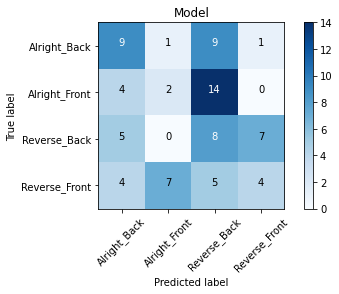

In [23]:
cm = confusion_matrix(y_true=test_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=test_set.class_indices, title='Model')

Sembla que conjelant algunes layers obtinc millors resultats. Provem canviant epochs de 20 a 50. Resultats interesants, pero no els millors, Opcions?? Doncs ni idea, intentar aplicar allo que deiem de la feature extraction, pero llavorens es un altre cami. 
Potser seria interesant trobar una manera de delimitar o parametritzar-ho, pero no ho se si te molt de sentit, no es pot generalitzar gaire. 